## 축산 검정 성적 데이터 EDA

In [1]:
# 표준 라이브러리
import sys
from pathlib import Path
from typing import List, Dict
from itertools import combinations

# 서드파티 라이브러리
import pandas as pd
import plotly.express as px
import numpy as np
import missingno as ms
import seaborn as sns

# 로컬 모듈
sys.path.append(str(Path.cwd().parent))
from utils import DATA_DIR
from utils import eda_missing_data, eda_duplicates, plot_features

In [2]:
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False

mpl.rcParams['axes.unicode_minus'] = False

# 폰트 개인 경로에 맞춰서 변경
# FONT_DIR = Path("/path/to/fonts")
# font_path = FONT_DIR / 'FREESENTATION-6SEMIBOLD.ttf'
# prop = fm.FontProperties(fname=font_path)

### 검정 성적 원본 데이터 불러오기

In [32]:
pandas_kwargs = {
    'memory_map': True,
    'dtype': {
        '검정일자': float,
        '출생일자': float,
    },
    'parse_dates': ['검정일자', '출생일자', '최근분만일(연계)', '최근건유일(연계)', '가수제일자(연계)', '최종수정일자(연계)'],
    'date_format': '%Y%m%d.0'
}

milk_data: pd.DataFrame = pd.read_csv(DATA_DIR / 'raw' / '유성분검사성적서.csv', **pandas_kwargs)
milk_data.head()

/var/folders/zp/b80h2w41309d2z9qmnh381hw0000gn/T/ipykernel_78268/1486750684.py:11: DtypeWarning: Columns (30,48) have mixed types. Specify dtype option on import or set low_memory=False.
  milk_data: pd.DataFrame = pd.read_csv(DATA_DIR / 'raw' / '유성분검사성적서.csv', **pandas_kwargs)


,농장아이디,착유일련번호,개체번호,혈통번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,...,최종수정정액코드(연계),체점수(연계),분만후첫수정일까지일수,데이터입력코드,유량,유성분검사일련번호,검정일시(ICT),단백율,고형율,유당
0,20249,NaN,2.012071e+13,NaN,2020-01-11,154,6.31,2.86,8.43,141,...,250HO13267,NaN,186.0,S04303,59950,NaN,NaN,NaN,NaN,NaN
1,20249,NaN,2.012063e+13,NaN,2020-01-11,457,0.00,0.00,0.00,0,...,7HO13250,NaN,127.0,S04303,59951,NaN,NaN,NaN,NaN,NaN
2,20249,NaN,2.012050e+13,NaN,2020-01-11,52,6.10,2.80,8.53,34,...,200HO06480,NaN,64.0,S04303,59945,NaN,NaN,NaN,NaN,NaN
3,20249,NaN,2.011101e+13,NaN,2020-01-11,115,4.34,3.05,8.97,106,...,14HO07770,NaN,50.0,S04303,59947,NaN,NaN,NaN,NaN,NaN
4,20249,NaN,2.012101e+13,NaN,2020-01-11,290,5.56,3.70,9.23,220,...,7HO13250,NaN,180.0,S04303,59958,NaN,NaN,NaN,NaN,NaN


In [33]:
milk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100549 entries, 0 to 100548
Data columns (total 53 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   농장아이디         100549 non-null  int64         
 1   착유일련번호        0 non-null       float64       
 2   개체번호          92014 non-null   float64       
 3   혈통번호          0 non-null       float64       
 4   검정일자          100549 non-null  datetime64[ns]
 5   누적착유일(연계)     100549 non-null  int64         
 6   유지방율          100549 non-null  float64       
 7   유단백           100549 non-null  float64       
 8   무지고형분         100549 non-null  float64       
 9   체세포수          100549 non-null  int64         
 10  우유내요소태질소      100549 non-null  float64       
 11  305일유량        100549 non-null  float64       
 12  305일유지량       100549 non-null  float64       
 13  305일유단백       100549 non-null  float64       
 14  305일무지고형분     100549 non-null  float64       
 15  성년유량          100

In [34]:
milk_data.columns[30], milk_data.columns[48]

('농장관리번호', '유성분검사일련번호')

In [35]:
# 문제 컬럼 확인
try:
    milk_data['농장관리번호'].astype(float)
except Exception as e:
    print(e)

try:
    milk_data['유성분검사일련번호'].astype(float)
except Exception as e:
    print(e)

could not convert string to float: '?？1'
could not convert string to float: '6007-05-20 00:00:00.0'


In [36]:
milk_data['농장관리번호'].str.startswith('?').value_counts()

농장관리번호
False    81894
True        26
Name: count, dtype: int64

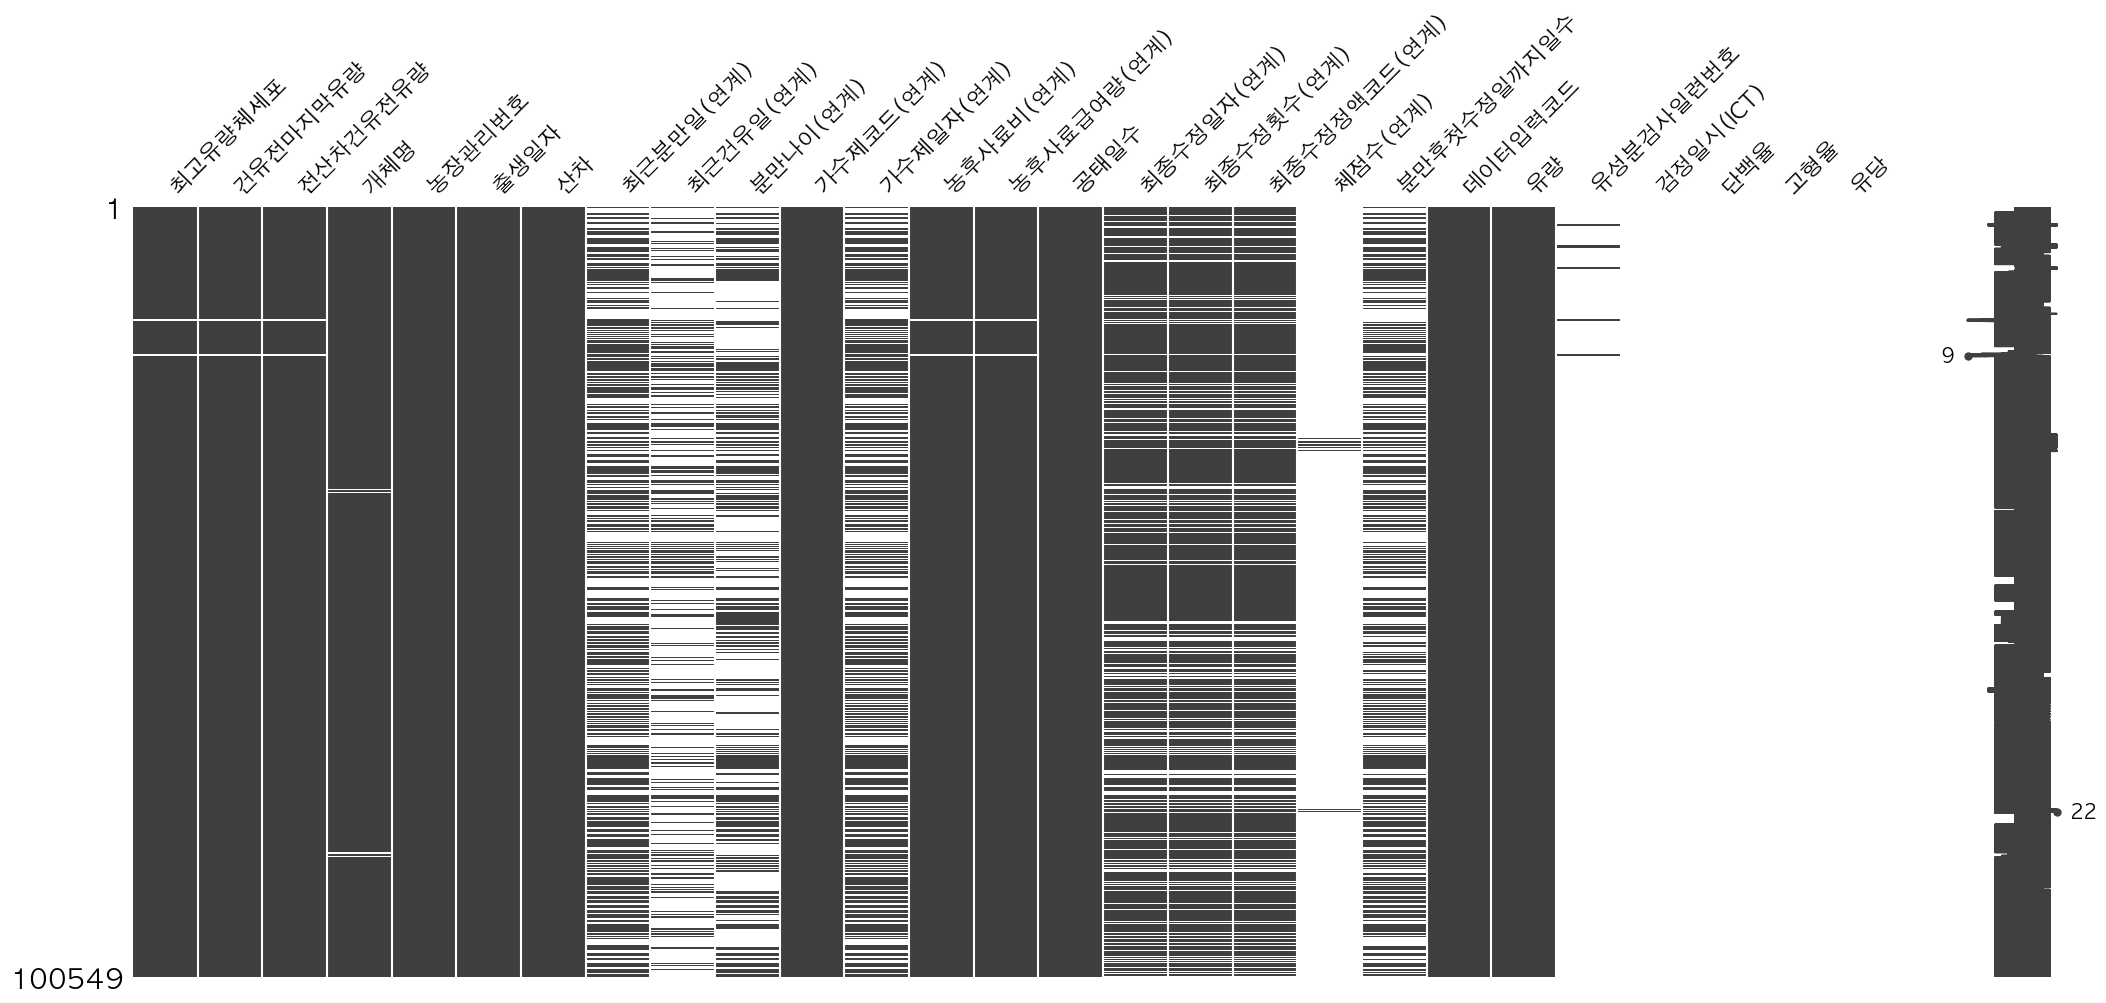

최고유량체세포            623
건유전마지막유량           623
전산차건유전유량           623
개체명                563
농장관리번호               0
출생일자                 0
산차                   0
최근분만일(연계)        39883
최근건유일(연계)        70038
분만나이(연계)         58382
가수제코드(연계)            0
가수제일자(연계)        39867
농후사료비(연계)          623
농후사료급여량(연계)        623
공태일수                 0
최종수정일자(연계)       18628
최종수정횟수(연계)       18628
최종수정정액코드(연계)     18628
체점수(연계)          99490
분만후첫수정일까지일수      44340
데이터입력코드              0
유량                   0
유성분검사일련번호        98953
검정일시(ICT)       100549
단백율             100549
고형율             100549
유당              100549
dtype: int64

In [37]:
eda_missing_data(milk_data.iloc[:, 26:])

In [38]:
drop_cols = ['체점수(연계)', '유성분검사일련번호', '검정일시(ICT)', '단백율', '고형율', '유당']

milk_data.drop(columns=drop_cols, inplace=True)

In [39]:
milk_data.shape

(100549, 47)

In [40]:
milk_data.nunique()

농장아이디              49
착유일련번호              0
개체번호             5411
혈통번호                0
검정일자              514
누적착유일(연계)         800
유지방율              767
유단백               328
무지고형분             393
체세포수             1823
우유내요소태질소          330
305일유량           8285
305일유지량           757
305일유단백           453
305일무지고형분        1097
성년유량             8198
성년유지량             744
성년유단백량            444
성년무지고형분량         1100
전산차비유지속성          794
현재산차비유지속성         131
비유최고도달일수          480
비유후기최고유량           73
비유초기평균유지율         560
비유초기평균단백율         226
비유초기평균MNU          38
최고유량체세포           728
건유전마지막유량          201
전산차건유전유량          405
개체명              5583
농장관리번호           3521
출생일자             2453
산차                 12
최근분만일(연계)        1248
최근건유일(연계)         732
분만나이(연계)            2
가수제코드(연계)          13
가수제일자(연계)        1197
농후사료비(연계)          96
농후사료급여량(연계)        48
공태일수              504
최종수정일자(연계)       1069
최종수정횟수(연계)         19
최종수정정액코드(연계)      368
분만후첫수정일까지일수       293
데이터입력코드   

In [41]:
milk_data.describe()

,농장아이디,착유일련번호,개체번호,혈통번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,...,출생일자,산차,분만나이(연계),가수제코드(연계),농후사료비(연계),농후사료급여량(연계),공태일수,최종수정횟수(연계),분만후첫수정일까지일수,유량
count,100549.000000,0.0,9.201400e+04,0.0,100549,100549.000000,100549.000000,100549.000000,100549.000000,100549.000000,...,100549,100549.00000,42167.000000,100549.000000,99926.000000,99926.000000,100549.000000,81921.000000,56209.000000,1.005490e+05
mean,20947.491004,NaN,2.017478e+13,NaN,2020-12-27 13:11:54.027986432,130.211887,1.933651,1.538812,4.101352,81.634924,...,2017-11-15 21:40:21.995245824,1.36426,1.044087,83.206924,504.911414,1.552443,80.262151,2.477094,96.385187,4.758180e+07
min,20249.000000,NaN,2.007121e+13,NaN,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,...,2006-03-08 00:00:00,0.00000,1.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00
25%,20273.000000,NaN,2.016093e+13,NaN,2020-07-10 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,...,2016-09-20 00:00:00,0.00000,1.000000,81.000000,0.000000,0.000000,0.000000,1.000000,60.000000,1.591305e+07
50%,21138.000000,NaN,2.018041e+13,NaN,2020-12-23 00:00:00,63.000000,0.000000,0.000000,0.000000,0.000000,...,2018-03-25 00:00:00,1.00000,1.000000,82.000000,0.000000,0.000000,0.000000,2.000000,82.000000,7.613471e+07
75%,21278.000000,NaN,2.019071e+13,NaN,2021-06-16 00:00:00,240.000000,4.060000,3.270000,8.820000,60.000000,...,2019-06-21 00:00:00,2.00000,1.000000,99.000000,0.000000,0.000000,136.000000,3.000000,117.000000,7.618873e+07
max,21876.000000,NaN,2.021091e+13,NaN,2022-02-04 00:00:00,1101.000000,9.990000,8.900000,13.930000,20484.000000,...,2021-10-25 00:00:00,11.00000,2.000000,99.000000,27750.000000,50.000000,974.000000,24.000000,579.000000,9.583739e+07
std,577.740711,NaN,2.128230e+10,NaN,NaN,155.299551,2.176380,1.676839,4.431793,311.839255,...,NaN,1.56425,0.205290,22.201224,1518.201944,3.647376,117.318877,1.976458,54.723277,3.063508e+07


In [66]:
milk_data.duplicated().sum()

np.int64(5516)

In [73]:
milk_data.drop_duplicates(inplace=True)

In [ ]:
eda_duplicates(milk_data, columns=['개체번호', '농장관리번호', '검정일자'])

'=================================================='

'컬럼 1개 PK 검사'

'=================================================='

'개체번호의 PK 검사'

True     89621
False     5412
Name: count, dtype: int64

'농장관리번호의 PK 검사'

True     91512
False     3521
Name: count, dtype: int64

'출생일자의 PK 검사'

True     92580
False     2453
Name: count, dtype: int64

'검정일자의 PK 검사'

True     94519
False      514
Name: count, dtype: int64

'=================================================='

'컬럼 2개 PK 검사'

'=================================================='

'개체번호와 농장관리번호의 PK 검사'

True     86816
False     8217
Name: count, dtype: int64

'개체번호와 출생일자의 PK 검사'

True     89036
False     5997
Name: count, dtype: int64

'개체번호와 검정일자의 PK 검사'

False    88246
True      6787
Name: count, dtype: int64

'농장관리번호와 출생일자의 PK 검사'

True     87319
False     7714
Name: count, dtype: int64

'농장관리번호와 검정일자의 PK 검사'

False    89649
True      5384
Name: count, dtype: int64

'출생일자와 검정일자의 PK 검사'

False    85560
True      9473
Name: count, dtype: int64

'=================================================='

'컬럼 3개 PK 검사'

'=================================================='

'개체번호와 농장관리번호와 출생일자의 PK 검사'

True     86742
False     8291
Name: count, dtype: int64

'개체번호와 농장관리번호와 검정일자의 PK 검사'

False    95033
Name: count, dtype: int64

'개체번호와 출생일자와 검정일자의 PK 검사'

False    94741
True       292
Name: count, dtype: int64

'농장관리번호와 출생일자와 검정일자의 PK 검사'

False    92861
True      2172
Name: count, dtype: int64

'=================================================='

'컬럼 4개 PK 검사'

'=================================================='

'개체번호와 농장관리번호와 출생일자와 검정일자의 PK 검사'

False    95033
Name: count, dtype: int64

In [43]:
milk_data.iloc[:, 26:].columns

Index(['최고유량체세포', '건유전마지막유량', '전산차건유전유량', '개체명', '농장관리번호', '출생일자', '산차',
       '최근분만일(연계)', '최근건유일(연계)', '분만나이(연계)', '가수제코드(연계)', '가수제일자(연계)',
       '농후사료비(연계)', '농후사료급여량(연계)', '공태일수', '최종수정일자(연계)', '최종수정횟수(연계)',
       '최종수정정액코드(연계)', '분만후첫수정일까지일수', '데이터입력코드', '유량'],
      dtype='object')

In [44]:
milk_data.iloc[:, 26:].dtypes

최고유량체세포                float64
건유전마지막유량               float64
전산차건유전유량               float64
개체명                     object
농장관리번호                  object
출생일자            datetime64[ns]
산차                       int64
최근분만일(연계)               object
최근건유일(연계)               object
분만나이(연계)               float64
가수제코드(연계)                int64
가수제일자(연계)               object
농후사료비(연계)              float64
농후사료급여량(연계)            float64
공태일수                     int64
최종수정일자(연계)              object
최종수정횟수(연계)             float64
최종수정정액코드(연계)            object
분만후첫수정일까지일수            float64
데이터입력코드                 object
유량                       int64
dtype: object

In [90]:
grouped = milk_data.groupby('개체번호').agg({
    '개체명': ['unique', 'nunique'],
    '농장아이디': ['unique']
})

cond = grouped[('개체명', 'nunique')] > 1
grouped[cond]

개체명          \
                                                  unique nunique   
개체번호                                                               
2.013101e+13                      [진성빅토리포티피3330호, 대흥727]       2   
2.015120e+13          [밀키웨이마그네티즘모글0633호, 밀키웨이마그네티즘모글712]       2   
2.016022e+13                    [승수71(3719), 로뎀구스리돔3582]       2   
2.016030e+13                 [유옥ㄱ백스터도르시584, 유옥백스터도르시584]       2   
2.016082e+13                [거창615호, 378_광명 메든 프레디 378호]       2   
2.017073e+13                [466_두레 레이 브랜슨 466호, 수미들226]       2   
2.017090e+13                        [두희샴록시드602, 유아름578호]       2   
2.017111e+13       [두희 페이스북 지 더블유 앳우드 611호 , 동청파사노버츠271]       2   
2.018013e+13                          [수미들8464, 수산나8464]       2   
2.018032e+13                [이철주512호, 서부 HK-212 프라이드  호]       2   
2.018070e+13        [251_하은 체이스 탱고 251호, 광명 프레디 자렙 413호]       2   
2.018072e+13                    [동청메이페이길레스파이299, 토성9789]       2   
2.018073e+13                   [이철주527호, 동청돈길레스파이301-쌍자]       2   
2.018081e+13                    [수산나0032, 두희골드윈메이플라워637]       2   
2.018082e+13  [로뎀걸프에어인테이크1783, 1815_한아름 브라울러 알타로블 1815호]       2   
2.018091e+13                 [화랑에픽빌링스6365, 다현 5501(318)]       2   
2.019021e+13        [0268_영심 라드 피 레드 애이크맨 0268호, 승수8722]       2   
2.019063e+13                           [수산나6420, 소원387호]       2   
2.019092e+13                       [무릉6196(모13), 무릉6196]       2   
2.019092e+13                       [무릉6195(모15), 무릉6195]       2   
2.019100e+13                [마음 9054, 광명 산타나 피라냐-피 437호]       2   
2.019102e+13                           [대지 9161, 토성7135]       2   
2.020071e+13                 [토성5344, 송산 알타카니발 조슈퍼 584호]       2   
2.020083e+13                        [두희피버제다이714, 토성5624]       2   
2.020103e+13                        [두희부켐듀크721, 수산나7266]       2   
2.020112e+13                      [두희하이옥탄듀크727, 수산나7306]       2   
2.021010e+13               [동물8456(226), 동물8456(226) 19]       2   
2.021010e+13             [동물 5025(228), 동물 5025(228) 46]       2   
2.021010e+13             [동물 9292(233), 동물 9292(233) 10]       2   
2.021010e+13             [동물 4486(235), 동물 4486(235) 42]       2   
2.021010e+13             [동물 4765(236), 동물 4765(236) 53]       2   
2.021010e+13             [동물 6755(237), 동물 6755(237) 55]       2   
2.021010e+13             [동물 1304(240), 동물 1304(240) 43]       2   
2.021010e+13             [동물 2241(241), 동물 2241(241) 52]       2   
2.021010e+13              [동물 2254(242), 동물 2254(242) 3]       2   
2.021010e+13             [동물 2305(243), 동물 2305(243) 19]       2   
2.021010e+13             [동물 8034(247), 동물 8034(247) 37]       2   
2.021010e+13                      [유밀원 7012(722), 유진634]       2   
2.021021e+13                [송산 에즈라 핸썸 602호, 동청도어맨실버383]       2   

                       농장아이디  
                      unique  
개체번호                          
2.013101e+13  [21135, 21143]  
2.015120e+13         [20249]  
2.016022e+13  [21138, 21139]  
2.016030e+13         [21142]  
2.016082e+13  [20278, 21678]  
2.017073e+13  [20268, 21145]  
2.017090e+13  [21141, 21876]  
2.017111e+13  [21141, 21680]  
2.018013e+13         [21134]  
2.018032e+13  [21144, 21133]  
2.018070e+13  [21676, 21678]  
2.018072e+13  [21680, 21688]  
2.018073e+13  [21144, 21680]  
2.018081e+13  [21134, 21141]  
2.018082e+13  [21139, 21686]  
2.018091e+13  [20273, 21150]  
2.019021e+13  [20269, 21138]  
2.019063e+13  [21134, 21679]  
2.019092e+13         [20251]  
2.019092e+13         [20251]  
2.019100e+13  [21275, 21678]  
2.019102e+13  [21137, 21688]  
2.020071e+13  [21688, 21146]  
2.020083e+13  [21141, 21688]  
2.020103e+13  [21141, 21134]  
2.020112e+13  [21141, 21134]  
2.021010e+13         [21149]  
2.021010e+13         [21149]  
2.021010e+13         [21149]  
2.021010e+13         [21149]  
2.021010e+13         [21149]  
2.021010e+13         [21149]  
2.021010e+13         [21149]  
2.021010e+13         [21149]  
2.021010e+13         [21149]  
2.021010e+13      

In [88]:
milk_data[milk_data['개체번호'] == 20151201020162.0].sort_values('검정일자')[['농장아이디', '개체번호', '개체명', '검정일자', '유량']]

,농장아이디,개체번호,개체명,검정일자,유량
25,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-01-11,59874
130,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-02-12,60014
248,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-03-12,60161
366,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-04-12,60308
494,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-05-13,15070474
622,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-06-14,49410
796,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-07-17,49218
969,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-08-19,319166
1144,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-09-25,277721
1319,20249,2.015120e+13,밀키웨이마그네티즘모글0633호,2020-10-21,318979


In [47]:
grouped = milk_data.groupby('개체명')['개체번호'].agg(['unique', 'nunique'])

cond = grouped['nunique'] > 1
grouped[cond]

,unique,nunique
개체명,,
048_조란 아틀랜틱 탱고 048호,"[20180113010032.0, 20180113010138.0]",2
대지 1669,"[20160622010025.0, 20170606010053.0]",2
대흥1022,"[20141228010026.0, 20190215010134.0]",2
대흥1025,"[20150107010108.0, 20190223010136.0]",2
대흥1028,"[20150118010002.0, 20190310010139.0]",2
대흥1029,"[20150205010003.0, 20190312010140.0]",2
대흥1034,"[20150328010061.0, 20190416010144.0]",2
대흥1042,"[20150520010062.0, 20190702010151.0]",2
대흥1050,"[20150710010027.0, 20190802010158.0]",2


In [56]:
milk_data[milk_data['개체명'] == '대흥1054'].sort_values('검정일자')[['농장아이디', '개체번호', '개체명', '검정일자', '유량']]

,농장아이디,개체번호,개체명,검정일자,유량
29744,21143,2.015071e+13,대흥1054,2020-01-22,15891198
29854,21143,2.019082e+13,대흥1054,2020-01-22,15891318
29905,21143,2.015071e+13,대흥1054,2020-02-29,15891453
30015,21143,2.019082e+13,대흥1054,2020-02-29,15891482
30066,21143,2.015071e+13,대흥1054,2020-03-25,15891662
30176,21143,2.019082e+13,대흥1054,2020-03-25,15891784
30227,21143,2.015071e+13,대흥1054,2020-04-22,15891905
30337,21143,2.019082e+13,대흥1054,2020-04-22,15891913
30401,21143,2.015071e+13,대흥1054,2020-05-20,15892168
30511,21143,2.019082e+13,대흥1054,2020-05-20,15892170


## 개체 구분자 탐색

In [79]:
duplicate_cond1 = milk_data.duplicated(subset=['개체번호', '농장아이디', '검정일자'], keep='first')
duplicate_cond2 = milk_data.duplicated(subset=['개체번호', '농장아이디', '검정일자'], keep='last')

milk_data[duplicate_cond1].sort_values('검정일자').reset_index(drop=True).compare(milk_data[duplicate_cond2].sort_values('검정일자').reset_index(drop=True))

누적착유일(연계)        유지방율        유단백       무지고형분       체세포수        ...  \
          self  other self other self other  self other self other  ...   
0          0.0  232.0  0.0  4.32  0.0  3.86   0.0   9.5  0.0  37.0  ...   
1          NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   
2          NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   
3          NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   
4          NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   
...        ...    ...  ...   ...  ...   ...   ...   ...  ...   ...  ...   
6744       NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   
6745       NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   
6746       NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   
6747       NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   
6748       NaN    NaN  NaN   NaN  NaN   NaN   NaN   NaN  NaN   NaN  ...   

     최종수정일자(연계)           최종수정횟수(연계)       최종수정정액코드(연계)             \
           self     other       self other         self      other   
0      20200225  20190831        2.0   1.0     7HO12344  29HO17553   
1      20190826  20190714        NaN   NaN          NaN        NaN   
2      20190714  20190629        NaN   NaN          NaN        NaN   
3      20190629  20190518        NaN   NaN          NaN        NaN   
4      20190518  20191019        1.0   3.0          NaN        NaN   
...         ...       ...        ...   ...          ...        ...   
6744        NaN       NaN        NaN   NaN          NaN        NaN   
6745        NaN       NaN        NaN   NaN          NaN        NaN   
6746        NaN       NaN        NaN   NaN          NaN        NaN   
6747        NaN       NaN        NaN   NaN          NaN        NaN   
6748        NaN       NaN        NaN   NaN          NaN        NaN   

     분만후첫수정일까지일수                 유량              
            self  other        self       other  
0            NaN  110.0  76585352.0  76585351.0  
1            NaN    NaN  76585366.0  76585365.0  
2            NaN    NaN  76585365.0  76585364.0  
3            NaN    NaN  76585364.0  76585363.0  
4            NaN    NaN  76585363.0  76585362.0  
...          ...    ...         ...         ...  
6744         NaN    NaN  76275718.0  76275761.0  
6745         NaN    NaN  76275703.0  76275718.0  
6746         NaN    NaN  76275759.0  76275703.0  
6747         NaN    NaN  76275796.0  76275828.0  
6748         NaN    NaN  76275828.0  76275726.0  

[6749 rows x 82 columns]

In [69]:
milk_data[milk_data['농장관리번호'] == '809']

,농장아이디,착유일련번호,개체번호,혈통번호,검정일자,누적착유일(연계),유지방율,유단백,무지고형분,체세포수,...,가수제일자(연계),농후사료비(연계),농후사료급여량(연계),공태일수,최종수정일자(연계),최종수정횟수(연계),최종수정정액코드(연계),분만후첫수정일까지일수,데이터입력코드,유량
95,20249,NaN,2.018071e+13,NaN,2020-01-11,0,0.00,0.00,0.00,0,...,NaN,0.0,0.0,0,20191109,1.0,250HO12961,NaN,S04303,59929
200,20249,NaN,2.018071e+13,NaN,2020-02-12,0,0.00,0.00,0.00,0,...,NaN,0.0,0.0,0,20191109,1.0,250HO12961,NaN,S04303,60078
318,20249,NaN,2.018071e+13,NaN,2020-03-12,0,0.00,0.00,0.00,0,...,NaN,0.0,0.0,0,20191109,1.0,250HO12961,NaN,S04303,60224
436,20249,NaN,2.018071e+13,NaN,2020-04-12,0,0.00,0.00,0.00,0,...,NaN,0.0,0.0,0,20191109,1.0,250HO12961,NaN,S04303,60374
564,20249,NaN,2.018071e+13,NaN,2020-05-13,0,0.00,0.00,0.00,0,...,NaN,0.0,0.0,0,20191109,1.0,250HO12961,NaN,S04303,15070420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79890,21143,NaN,NaN,NaN,2021-07-20,9,4.28,3.39,9.01,197,...,20210711,0.0,0.0,0,20211015,1.0,11HO12209,97.0,S04303,76147454
80053,21143,NaN,NaN,NaN,2021-08-24,44,4.56,2.78,8.32,160,...,20210711,0.0,0.0,0,20211015,1.0,11HO12209,97.0,S04303,76148065
80211,21143,NaN,NaN,NaN,2021-09-18,69,4.65,2.79,8.34,65,...,20210711,0.0,0.0,0,20211015,1.0,11HO12209,97.0,S04303,76148670
80365,21143,NaN,NaN,NaN,2021-10-20,101,4.73,2.81,8.52,45,...,20210711,0.0,0.0,0,20211015,1.0,11HO12209,97.0,S04303,76149193


TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

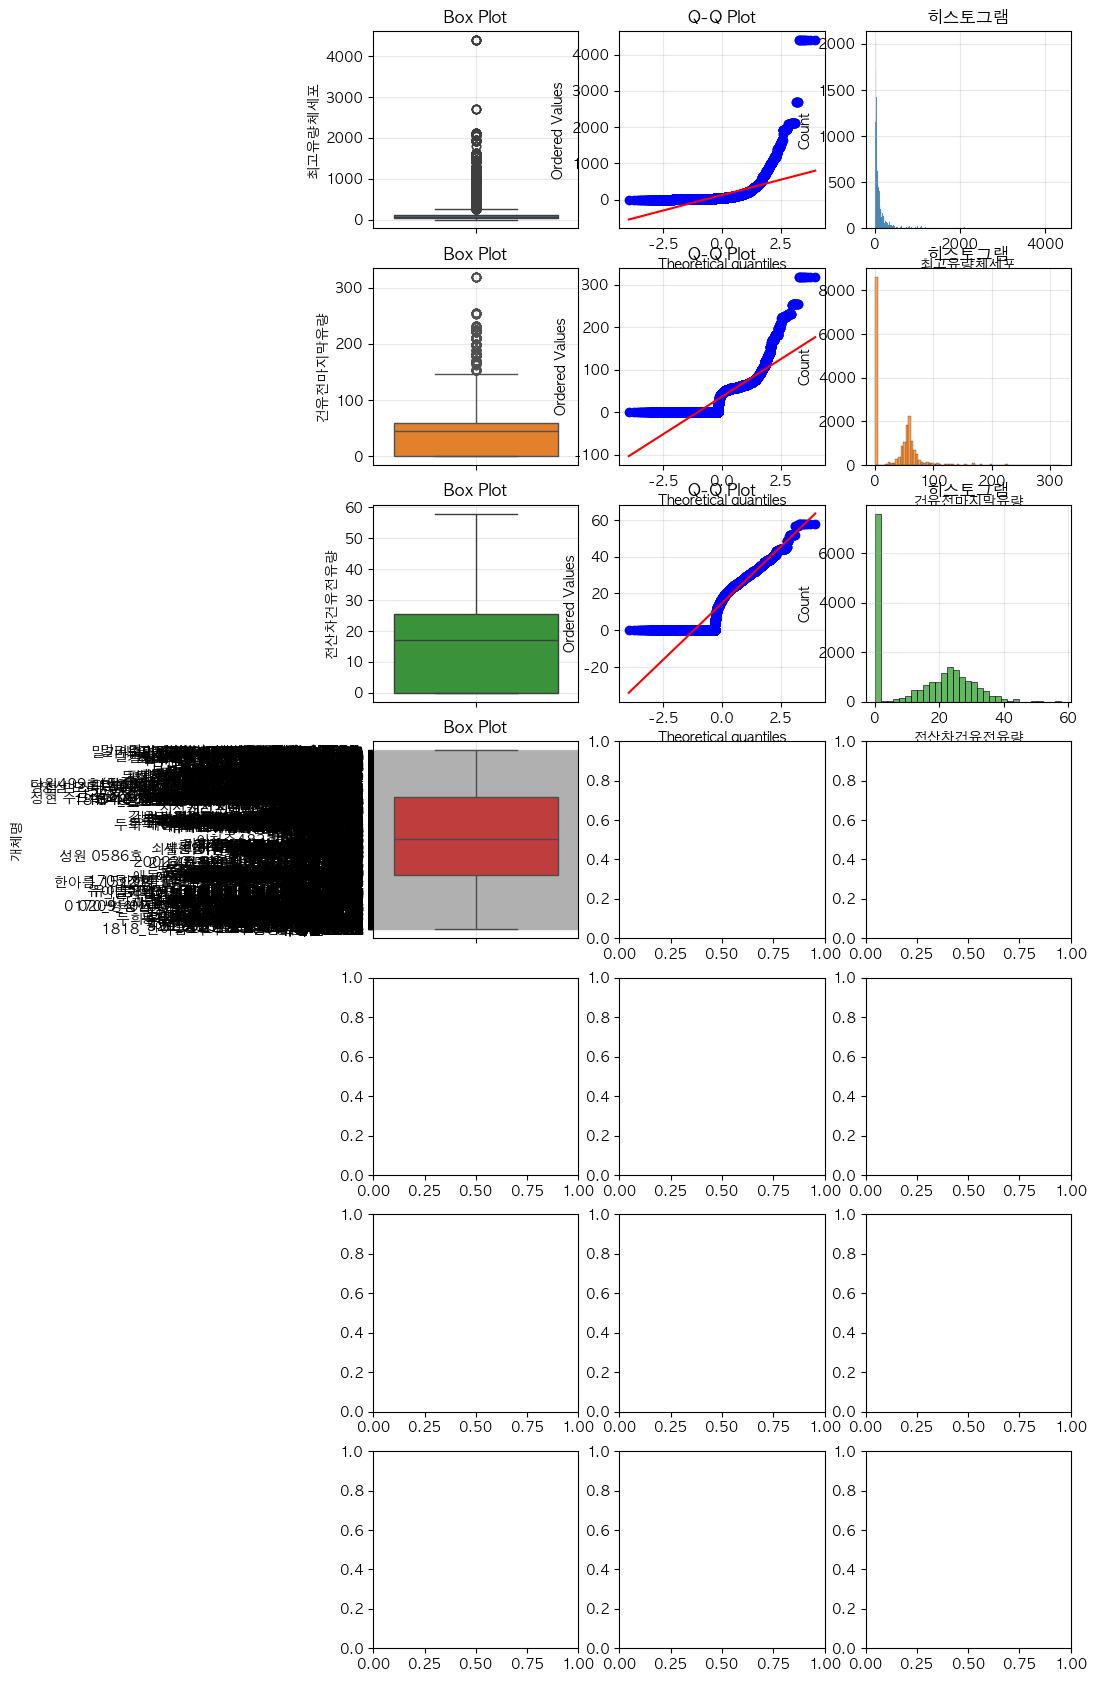

In [48]:
features = ['최고유량체세포', '건유전마지막유량', '전산차건유전유량', '개체명', '농장관리번호', '출생일자', '산차']


colors = [
    "#1f77b4",  # measDate
    "#ff7f0e",  # farm_cde
    "#2ca02c",  # itemCode
    "#d62728",  # flowerTop
    "#9467bd",  # grwtLt
    "#8c564b",  # lefCunt
    "#e377c2",  # lefLt
    "#7f7f7f",  # lefBt
    "#bcbd22",  # stemThck
    "#17becf",  # flanGrupp
    "#aec7e8",  # frtstGrupp
    "#ffbb78",  # hvstGrupp
    "#c5b0d5"   # frtstCo
]

# plot_features(tomato_mapping_data.dropna(), features, colors)
plot_features(milk_data.iloc[:, 26:].dropna(), features, colors)

In [ ]:
grouped = milk_data.groupby('농가명').agg({
    '개체번호': 'nunique',
    '유량': 'sum',
    '규모': 'max'
}).sort_values('개체번호')

KeyError: '농가명'

In [ ]:
size_map = {
    '100두 미만': 100,
    '100~200': 200,
    '200~300': 300,
    '300~400': 400,
    '400~500': 500,
    '500~1000': 1000
}

In [ ]:
grouped['두당유량'] = grouped['유량'] / grouped['개체번호']

grouped['크기'] = grouped['규모'].map(size_map)

In [ ]:
sns.boxplot(grouped, x='크기', y='두당유량', hue=grouped['크기'])
plt.xticks(rotation=90)
plt.show()

## 환경 정보 가져오기

In [ ]:
pandas_kwargs = {
    'memory_map': True,
    'index_col': 0
}

env_manage: pd.DataFrame = pd.read_csv(DATA_DIR / 'raw' / '환경관리기.csv', **pandas_kwargs)

In [ ]:
env_manage.nunique()

In [ ]:
em_farm = set(env_manage['농가명'].unique())
milk_farm = set(milk_data['농가명'].unique())

farms = list(int(x) for x in (em_farm & milk_farm))
farms

In [ ]:
cond = env_manage['장비종류'] == '온도'
cond &= env_manage['농가명'].isin(farms)
env_dict = {
    idx: env_manage[(env_manage['제조사아이디'] == idx) & cond]
    for idx in env_manage['제조사아이디']
}

In [ ]:
for idx, data in env_dict.items():
    if not data.empty:
        sns.boxplot(x=data['농가명'], y=data['측정값(℃ · % · ppm)'])
        plt.title(f'{idx}의 온도 데이터 - {len(data)}')
        plt.show()

## 착유 데이터 불러오기

In [ ]:
pandas_kwargs = {
    'memory_map': True
}


ict_data = pd.read_csv(DATA_DIR / 'raw' / 'ICT착유기.csv')
robot_data = pd.read_csv(DATA_DIR / 'raw' / '로봇착유기.csv')

In [ ]:
robot_data['농장아이디'].unique()

In [ ]:
env.to_csv(DATA_DIR / 'raw' / '환경관리기.csv', index=False)

In [ ]:
ict_data

In [ ]:
ict_farm = set(ict_data['농가명'].unique())
robot_farm = set(robot_data['농가명'].unique())

In [ ]:
display(robot_farm)
display(robot_farm & milk_farm)
display(robot_farm & milk_farm & em_farm)

In [ ]:
display(ict_farm)
display(ict_farm & milk_farm)
display(ict_farm & milk_farm & em_farm)

In [ ]:
ict_data['월'] = ict_data['측정일시'].dt.month

In [ ]:
sns.boxplot(x=ict_data['월'], y=ict_data['착유량(L)'])
plt.show()